In [1]:
# Training script for LazyConfig models
try:
    # ignore ShapelyDeprecationWarning from fvcore
    import warnings

    from shapely.errors import ShapelyDeprecationWarning

    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

except:
    pass
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger

setup_logger()

import gc
import os
import time

import detectron2.utils.comm as comm

# import some common libraries
import numpy as np
import torch

# import some common detectron2 utilities
from detectron2.config import LazyConfig, get_cfg
import detectron2.data as data
from detectron2.engine import (
    launch,
)

from deepdisc.data_format.augment_image import train_augs
from deepdisc.data_format.image_readers import DC2ImageReader
from deepdisc.data_format.register_data import (
    register_data_set,
)  # , register_loaded_data_set
from deepdisc.model.loaders import (
    RedshiftFlatDictMapper,
    return_test_loader,
    return_train_loader,
)
from deepdisc.model.models import (
    RedshiftPointCasROIHeads,
    RedshiftPointROIHeads,
    RedshiftPDFROIHeads,
    return_lazy_model,
)
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)
from deepdisc.utils.parse_arguments import make_training_arg_parser

In [2]:
# from rail.estimation.algos.deepdisc import DeepDiscInformer
import rail
from rail.estimation.algos.deepdisc import *
from rail.core.data import TableHandle, JsonHandle
from rail.core.stage import RailStage



In [14]:
#cfgfile = "./tests/configs/solo/solo_res50_DC2.py"
cfgfile = "./tests/configs/solo/solo_swin_DC2.py"

output_dir = "./"
output_name = "test"

trainfile = "/home/shared/hsc/DC2/test_data/dataset_3/flattened_images_train.hdf5"
testfile = "/home/shared/hsc/DC2/test_data/dataset_3/flattened_images_test.hdf5"
metadatafile = "/home/shared/hsc/DC2/test_data/dataset_3/train_metadata.json"
test_metadatafile = "/home/shared/hsc/DC2/test_data/dataset_3/test_metadata.json"


In [15]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [16]:
from deepdisc.data_format.file_io import get_data_from_json

metadata = get_data_from_json(metadatafile)
test_metadata = get_data_from_json(test_metadatafile)

In [17]:
training = DS.add_data(
    "training", data=None, handle_class=TableHandle, path=trainfile
)  # ()["images"]
testing = DS.add_data("testing", data=None, handle_class=TableHandle, path=testfile)

metadatahandle = DS.add_data("metadata", metadata, JsonHandle, path=metadatafile)

In [18]:
deep_dict = dict(
    chunk_size=100,
    epoch=20,
    batch_size=1,
    output_dir="./",
    cfgfile = cfgfile,
    num_gpus=1,
    print_frequency=5,
    head_epochs=1,
    full_epochs=1,
)

In [19]:
Inform = DeepDiscInformer.make_stage(
    name="Inform_DeepDISC", model="test_informer.pkl", **deep_dict
)

In [20]:
Inform.inform(training, metadatahandle)

Caching data
Training head layers
[12/15 17:40:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/15 17:40:22 d2.data.common]: Serializing 800 elements to byte tensors and concatenating them all ...
[12/15 17:40:25 d2.data.common]: Serialized dataset takes 220.12 MiB
[12/15 17:40:26 d2.data.build]: Making batched data loader with batch_size=1
[12/15 17:40:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/15 17:40:26 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[12/15 17:40:26 d2.data.common]: Serialized dataset takes 54.65 MiB
[12/15 17:40:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/shared/hsc/detectron2/projects/ViTDet/model_final_246a82.pkl ...


Skip loading parameter 'backbone.bottom_up.patch_embed.proj.weight' to the model due to incompatible shapes: (128, 3, 4, 4) in the checkpoint but (128, 6, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint 

[12/15 17:40:34 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  5  data time:  0.22763285599648952  loss time:  0.2924310751259327 dict_keys(['loss_cls_stage0', 'loss_box_reg_stage0', 'loss_cls_stage1', 'loss_box_reg_stage1', 'loss_cls_stage2', 'loss_box_reg_stage2', 'loss_mask', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [0.3908397853374481, 0.12995903193950653, 0.5078241229057312, 0.3109440803527832, 0.4126472473144531, 0.5495181083679199, 0.6312940716743469, 0.11008885502815247, 2.606322765350342, 0.4193018674850464] val loss:  0 lr:  [0.001]
Iteration:  10  data time:  0.22838465124368668  loss time:  0.29950876720249653 dict_keys(['loss_cls_stage0', 'loss_box_reg_stage0', 'loss_cls_stage1', 'loss_box_reg_stage1', 'loss_cls_stage2', 'loss_box_reg_stage2', 'loss_mask', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [0.6142467260360718, 0.14384672045707703, 0.6577302813529968, 0.38685983419418335, 0.6023541688919067, 0.6544270515441895, 0.5245046615600

### Inference

In [21]:
metadatahandle = DS.add_data(
    "metadata", test_metadata, JsonHandle, path=test_metadatafile
)

In [22]:
# Estimator = DeepDiscEstimator.make_stage(name='DeepDiscEstimator',
#                                       model=Inform.get_handle('model'), **deep_dict)

Estimator = DeepDiscPDFEstimator.make_stage(
    name="DeepDiscEstimator",
    model=Inform.get_handle("model"),
    # hdf5_groupname="images",
    **deep_dict,
)

In [23]:
results = Estimator.estimate(testing, metadatahandle)

caching data
[12/15 17:42:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./run.pth ...
Matching objects
Inserting handle into data store.  output_DeepDiscEstimator: inprogress_output_DeepDiscEstimator.hdf5, DeepDiscEstimator
Inserting handle into data store.  truth_DeepDiscEstimator: inprogress_truth_DeepDiscEstimator, DeepDiscEstimator


In [24]:
res = results.read()
res

In [25]:
truth = Estimator.get_handle("truth")

In [26]:
ztrue = truth.data["redshift"]

In [27]:
ztrue

[0.52962214, 0.3406593, 0.0, 0.42111164, 0.032379486, 0.0, 0.0]

In [19]:
from rail.evaluation.evaluator import Evaluator

In [20]:
deep_eval_dict = dict(
    chunk_size=100,
    zmin=-1,
    zmax=5,
    nzbins=200,
    epochs=20,
    output_name="test_evaluator",
    point_metrics="",
)

In [21]:
DeepEvaluator = Evaluator.make_stage(name="DeepDiscEvaluator", **deep_eval_dict)

In [22]:
eval_res = DeepEvaluator.evaluate(res, truth)

Inserting handle into data store.  input: None, DeepDiscEvaluator
Inserting handle into data store.  output_DeepDiscEvaluator: inprogress_output_DeepDiscEvaluator.hdf5, DeepDiscEvaluator


In [23]:
eval_res.data

{'PIT_AD_stat': array([0.29330632]),
 'PIT_AD_pval': array([nan]),
 'PIT_AD_significance_level': array([0.25]),
 'PIT_CvM_stat': array([0.39851584]),
 'PIT_CvM_pval': array([nan]),
 'PIT_CvM_significance_level': array([nan]),
 'PIT_KS_stat': array([0.08686274]),
 'PIT_KS_pval': array([nan]),
 'PIT_KS_significance_level': array([nan]),
 'PIT_OutRate_stat': array([nan]),
 'PIT_OutRate_pval': array([nan]),
 'PIT_OutRate_significance_level': array([nan]),
 'CDE_stat': array([-0.40906989]),
 'CDE_pval': array([nan])}

In [24]:
from qp.metrics.pit import PIT
from utils import *  # plot_pit_qq, ks_plot

pitobj = PIT(res, ztrue)
pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

In [25]:
from qp.ensemble import Ensemble


class Sample(Ensemble):
    """Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots."""

    def __init__(
        self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100
    ):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None

    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array(
                [self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))]
            )
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0.0, 1.0, n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f"Algorithm: {self._code}"
        name_str = f"Sample: {self._name}"
        line_str = "-" * (max(len(code_str), len(name_str)))
        text = str(
            line_str
            + "\n"
            + name_str
            + "\n"
            + code_str
            + "\n"
            + line_str
            + "\n"
            + f"{len(self)} PDFs with {len(self.zgrid)} probabilities each \n"
            + f"qp representation: {self.gen_class.name} \n"
            + f"z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive"
        )
        return text

    def plot_pdfs(self, gals, show_ztrue=True, show_photoz_mode=False):
        colors = plot_pdfs(
            self, gals, show_ztrue=show_ztrue, show_photoz_mode=show_photoz_mode
        )
        return colors

    def plot_old_valid(self, gals=None, colors=None):
        old_metrics_table = plot_old_valid(self, gals=gals, colors=colors)
        return old_metrics_table

    def plot_pit_qq(
        self,
        bins=None,
        label=None,
        title=None,
        show_pit=True,
        show_qq=True,
        show_pit_out_rate=True,
        savefig=False,
    ):
        """Make plot PIT-QQ as Figure 2 from Schmidt et al. 2020."""
        fig_filename = plot_pit_qq(
            self,
            bins=bins,
            label=label,
            title=title,
            show_pit=show_pit,
            show_qq=show_qq,
            show_pit_out_rate=show_pit_out_rate,
            savefig=savefig,
        )
        return fig_filename

In [26]:
def plot_pit_qq(
    pdfs,
    zgrid,
    ztrue,
    bins=None,
    title=None,
    code=None,
    show_pit=True,
    show_qq=True,
    pit_out_rate=None,
    savefig=False,
) -> str:
    """Quantile-quantile plot
        Ancillary function to be used by class Metrics.
    ​
        Parameters
        ----------
        pit: `PIT` object
            class from metrics.py
        bins: `int`, optional
            number of PIT bins
            if None, use the same number of quantiles (sample.n_quant)
        title: `str`, optional
            if None, use formatted sample's name (sample.name)
        label: `str`, optional
            if None, use formatted code's name (sample.code)
        show_pit: `bool`, optional
            include PIT histogram (default=True)
        show_qq: `bool`, optional
            include QQ plot (default=True)
        pit_out_rate: `ndarray`, optional
            print metric value on the plot panel (default=None)
        savefig: `bool`, optional
            save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"

    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(
            sample.qq[0], sample.qq[1], c="r", linestyle="-", linewidth=3, label=label
        )
        ax0.plot([0, 1], [0, 1], color="k", linestyle="--", linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel("Number")
            ax0.hlines(y_uni, xmin=0, xmax=1, color="k")
            plt.ylim(
                0,
            )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel("Number")
            ax1.hlines(y_uni, xmin=0, xmax=1, color="k")
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(
            sample.qq[0],
            (sample.qq[1] - sample.qq[0]),
            c="r",
            linestyle="-",
            linewidth=3,
        )
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color="k", linestyle="--", linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(
            np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
            np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]),
        )
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" + f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename

/tmp/ipykernel_657410/1507151644.py:92: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


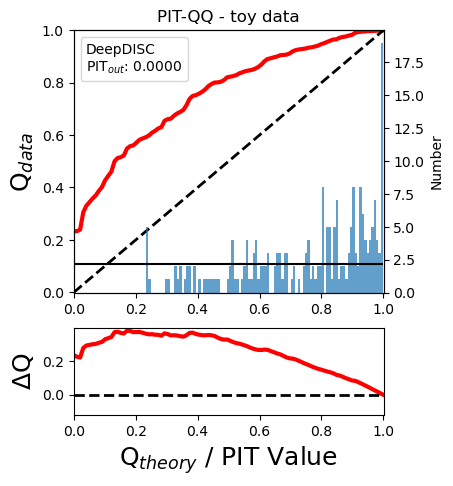

In [27]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from qp import interp


zgrid = np.linspace(-1, 5, 200)
pdfs = res.objdata()["yvals"]
plot_pit_qq(
    pdfs,
    zgrid,
    ztrue,
    title="PIT-QQ - toy data",
    code="DeepDISC",
    pit_out_rate=pit_out_rate,
    savefig=False,
)

In [28]:
res.objdata()

{'yvals': array([[8.82813963e-02, 9.55429727e-02, 1.03236807e-01, ...,
         2.06984589e-08, 1.63532923e-08, 1.28997072e-08],
        [8.81932290e-02, 9.54528518e-02, 1.03145059e-01, ...,
         2.04331210e-08, 1.61408231e-08, 1.27298026e-08],
        [1.04273174e-01, 1.12113823e-01, 1.20364568e-01, ...,
         5.36042694e-08, 4.29752429e-08, 3.44025281e-08],
        ...,
        [8.81738274e-02, 9.54329206e-02, 1.03124633e-01, ...,
         2.03848873e-08, 1.61021687e-08, 1.26989045e-08],
        [8.81722592e-02, 9.54313024e-02, 1.03122950e-01, ...,
         2.03826977e-08, 1.61004088e-08, 1.26974929e-08],
        [8.81910901e-02, 9.54508994e-02, 1.03143323e-01, ...,
         2.04044257e-08, 1.61178792e-08, 1.27114879e-08]])}